## Evaluating regression techniques for speaker characterization
### Laura Fernández Gallardo

In this notebook, I will evaluate the performance of different classification techniques for characterizing users. The aggregated subjective ratings (approximately normally-distributed) will be thresholded based on percentiles to define 3 classes ("high", "mid", and "low") with approximately the same number of samples.

As evaluation metrics, I will consider the per-class accuracy. Less confusions between the "high" and the "low" class are desired, while low accuracy recognizing the "middle class" would be less critical.

In [1]:
import io
import requests

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# fix random seed for reproducibility
seed = 2302
np.random.seed(seed)

### Speaker characteristics classes

We will first pbtain class labels from continuous numeric labels (see ../exploratory_analysis)

Let us start by looking at the traits for which listeners had slightly higher agreement: 

* _intelligent_
* _ugly_
* _old_
* _modest_
* _incompetent_

The files "SC_ratings_medians.csv" and "SC_ratings_medians.csv" have been generated in the data folder.

In [4]:
# load ratings (averaged across listeners)
ratings_means = pd.read_csv("../data/generated_data/ratings_SC_means.csv")

ratings_class = pd.DataFrame(index = ratings_means.index, columns=ratings_means.columns)

# for each trait, assign instances into 3 classes
for i in ratings_means.columns[2:]:
    # percentiles to threshold
    th = np.percentile(ratings_means[i],[33,66])
    ratings_class.loc[ratings_means[i]<th[0],i] = "low" 
    ratings_class.loc[ratings_means[i]>=th[0],i] = "mid" 
    ratings_class.loc[ratings_means[i]>th[1],i] = "high"
    
ratings_class.iloc[:,0:2] = ratings_means.iloc[:,0:2]     

Speech features have been extracted from the semi-spontaneous dialogs uttered by the 300 speakers of the [NSC corpus](http://www.qu.tu-berlin.de/?id=nsc-corpus). The 88 [eGeMAPS](http://ieeexplore.ieee.org/document/7160715/) speech features have been extracted (see ../feature_extraction) from each dialog. 

299 speakers recorded 4 semi-spontaneous dialogs, and 1 female speaker recorded 1 semi-spontaneous dialog. Total = 1197 speech files.

### Speech features

In [24]:
# load speech features

path = "https://raw.githubusercontent.com/laufergall/ML_Speaker_Characteristics/master/data/extracted_features/"

# load subjective questionnaire items and their translations
url = path + "/eGeMAPSv01a_NSC_semispontaneous.csv"
s = requests.get(url).content
feats =pd.read_csv(io.StringIO(s.decode('utf-8')), sep = ';')

feats.describe()

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
count,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,...,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,32.063095,0.167883,29.325017,32.086629,34.977246,5.652228,222.822954,363.513770,184.165744,358.118527,...,0.011332,0.013355,0.070748,2.746759,1.984108,0.221936,0.171029,0.281926,0.430044,-36.235466
std,5.279860,0.042437,5.572934,5.559050,5.492749,1.488526,84.112705,198.056559,88.143010,220.860099,...,0.015322,0.002160,0.022029,0.360294,0.216519,0.032219,0.031142,0.044972,0.062444,3.519597
min,19.996970,0.070875,16.151940,18.910790,22.498150,2.454426,43.314990,29.840620,24.406640,16.532470,...,-0.046577,0.004238,0.028813,1.719952,1.207464,0.131270,0.092938,0.173022,0.278871,-47.696250
25%,26.732420,0.137976,23.723620,26.314940,29.582180,4.654819,159.499600,208.677400,118.515500,175.743900,...,0.000949,0.011995,0.055470,2.505259,1.845700,0.198649,0.148853,0.250000,0.391928,-38.665310
50%,34.391110,0.159075,31.844520,34.913700,37.634500,5.528358,212.890900,328.966900,172.749000,319.463400,...,0.011202,0.013473,0.067683,2.731145,1.982276,0.219247,0.167914,0.277846,0.430810,-36.300370
75%,36.529880,0.194119,34.116070,36.815670,39.597080,6.410734,271.711000,480.879600,231.578100,504.927500,...,0.021377,0.014777,0.080935,2.971339,2.128973,0.243026,0.189839,0.308095,0.465424,-34.021020
max,41.109570,0.366876,38.905880,41.223580,44.217800,14.351590,564.901100,1084.662000,600.417200,1072.631000,...,0.062299,0.019842,0.193831,4.561631,2.729993,0.364091,0.305473,0.506615,1.314669,-24.839340


Pre-processing features:

* center and scale speech features of all data
* apply PCA to reduce the number of predictors

In [25]:
# Standardize speech features  

scaler = StandardScaler()
scaler.fit(feats.drop(['name'],axis=1))
feats_s = scaler.transform(feats.drop(['name'],axis=1)) # numpy 300x88

In [26]:
# Apply PCA and examine how many components to retain

pca = PCA()
pca.fit(feats_s)
feats_pca = pca.transform(feats_s) # np array 300 x n_pca-components
np.round(pca.explained_variance_ratio_,2)

array([ 0.2 ,  0.17,  0.1 ,  0.06,  0.04,  0.04,  0.03,  0.03,  0.02,
        0.02,  0.02,  0.02,  0.02,  0.01,  0.01,  0.01,  0.01,  0.01,
        0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
        0.01,  0.01,  0.01,  0.01,  0.01,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ])

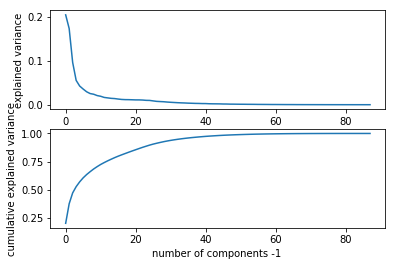

In [27]:
# Explained variance

plt.subplot(2, 1, 1)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components -1 ')
plt.ylabel('explained variance')

plt.subplot(2, 1, 2)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components -1 ')
plt.ylabel('cumulative explained variance')

plt.show()

We will retain the first 4 principal components, which account for 53% of the explained variance.

In [31]:
# selected pca components as pandas data frame
ncomp = 4
feats_pca_pd = pd.DataFrame(feats_pca[:,0:ncomp], columns = np.char.mod('PC_%d', np.arange(ncomp)))

Unfortunately, no subjective ratings have been collected for the spontaneous dialogs d5, d7, or d8. However, we use the speech features in order to have more instances with which to train and test the models.

**I assume** that the speakers' trait classes remain constant across recordings, that is, is a speaker is perceived as 'high' in the _intelligent_ trait for dialog 6 (d6, pizza dialog), then this perception would be the same for the other dialogs uttered by the same speaker.

In [38]:
# extract speaker ID from speech file name
feats_pca_pd['speaker_ID'] = feats['name'].str.slice(2, 5).astype('int') # shape: 1197, 90

# appending class label
feats_pca_class = feats_pca_pd.merge(ratings_class)

Text(0,0.5,'PC_1')

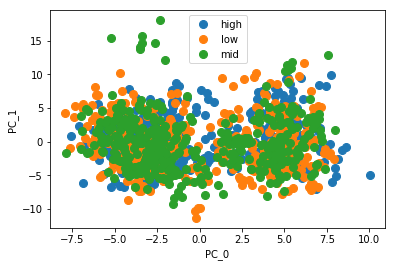

In [44]:
# plot first pca components for one trait

feats_grouped = feats_pca_pd.groupby(feats_pca_class['intelligent'].astype("category"))

fig, ax = plt.subplots()
for name, group in feats_grouped:
    ax.plot(group.PC_0, group.PC_1, marker='o', linestyle='', ms=8, label=name)
ax.legend()
ax.set_xlabel('PC_0')
ax.set_ylabel('PC_1')

It looks like the class separation is going to be challenging!

### Model tuning

Let us go on with:

Database partitions: consider train/dev partitions and cross-validation.
Test data will be utterances from other dialogues, given the (somewhat strong) assumption that traits stay constant over time.

* Split the available data to find the model and its hyperparameters leading to the best performance 
* Stratified cross-validation for hyperparameter tuning
* Check performance in test

(Nested hyperparameter tuning inspired by [A. Zheng](http://www.oreilly.com/data/free/evaluating-machine-learning-models.csp))

In [62]:
feats_pca_class.columns

Index(['PC_0', 'PC_1', 'PC_2', 'PC_3', 'speaker_ID', 'speaker_gender',
       'non_likable', 'secure', 'attractive', 'unsympathetic', 'indecisive',
       'unobtrusive', 'distant', 'bored', 'emotional', 'not_irritated',
       'active', 'pleasant', 'characterless', 'sociable', 'relaxed',
       'affectionate', 'dominant', 'unaffected', 'hearty', 'old', 'personal',
       'calm', 'incompetent', 'ugly', 'friendly', 'masculine', 'submissive',
       'indifferent', 'interesting', 'cynical', 'artificial', 'intelligent',
       'childish', 'modest'],
      dtype='object')

In [60]:
feats_pca_class.loc['PC_0','PC_1']

KeyError: 'the label [PC_0] is not in the [index]'

In [50]:
X = feats_pca_pd.values
y = feats_pca_class['intelligent']

# for mf in model_family_list:
    
# split data into 80% and 20% subsets
# give subset A to the inner hyperparameter tuner,
# save subset B for meta-evaluation
AX, BX, Ay, By = train_test_split(X, y, test_size=0.20, random_state=2302)


In [72]:
## (quick working example knn)

from sklearn.neighbors import KNeighborsClassifier
knn2 = KNeighborsClassifier(n_neighbors=1)
knn2.fit(AX, Ay)
print("mean accuracy =",knn2.score(BX,By)) # this is the same as average recall of classif report
pred = knn2.predict(BX)
print(classification_report(By,pred))
print(confusion_matrix(By, pred)) # i = true / j = predicted
#sns.heatmap(cm)

mean accuracy = 0.466666666667
             precision    recall  f1-score   support

       high       0.42      0.50      0.46        16
        low       0.61      0.44      0.51        25
        mid       0.39      0.47      0.43        19

avg / total       0.49      0.47      0.47        60

[[ 8  3  5]
 [ 5 11  9]
 [ 6  4  9]]


Hyperparam tuning using only subset A (AX, Ay) <- GridSearchCV

In [ ]:
# all imports (classifiers)

from sklearn.neighbors import KNeighborsClassifier

In [119]:
# init lists

classifiers_names = []
classifiers = []
hparam_grids = []
grid_results = []
best_accs = [] # on the B set
best_hps = [] 

K Nearest Neighbors

In [120]:
knn = KNeighborsClassifier()

n_neighbors = list(range(1,50))
hp = dict(n_neighbors = n_neighbors)

# append classifier and parameters to our lists
classifiers_names.append("K Nearest Neighbors")
classifiers.append(knn)
hparam_grids.append(hp)

#### Hyperparameter tuning for each classifier

Helper functions

In [125]:
# summarize results given 
# - classifier name
# - gridsearch results for a classifier 
# - and name of file to write the summary to

def summary_tuning(cname, grid_result, file):
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']

    # print best result and append to our lists
    print("%r -> Best: %f using %s\n" % (cname, grid_result.best_score_, grid_result.best_params_))

    # write means, stds, params to file
    file.write("\n")
    for mean, stdev, param in zip(means, stds, params):
        file.write("%r, %f (%f) with: %r\n" % (cname, mean, stdev, param))

In [126]:
# main loop to tune hyperparameters for each classifier

for i in np.arange(len(classifiers)):
    
    # perform grid search
    grid = GridSearchCV(estimator=classifiers[i], 
                        param_grid=hparam_grids[i], 
                        n_jobs=1, 
                        cv=10)
    grid_result = grid.fit(AX, Ay) # This takes a while
    
    # append grid search results to our lists
    grid_results.append(grid_result)
    
    # summary of hp tuning
    summary_tuning(classifiers_names[i], 
                   grid_result, 
                   open("summary_modelTuning.txt","a"))
    
    # evaluate classifier on set B
    test_score = grid_result.best_estimator_.score(BX, By)
    best_accs.append(test_score)
    best_hps.append(grid_result.best_params_)
    
    

'K Nearest Neighbors' -> Best: 0.379167 using {'n_neighbors': 3}



Cross-validation for partitions A-B: 
- make an average of best_accs after testing for each classifier


Now, select the classifier that gave the maximum acc on B.

In [160]:
# select classifier based on max acc on B set
index = best_accs.index(max(best_accs))
cls = classifiers[index]
cls.set_params(**best_hps[index])

# train using all data with this classifier
cls.fit(X,y)

# X,y would be from my train data. 
# Then, I have test data from other dialogs - let us see the performance

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [ ]:
# Now, do all this stuff in CV (in each fold, use different A, B data)

# I think this would be the way to go:
k_fold = StratifiedKFold(n_splits=3)
[my_function() for train, test in k_fold.split(X_digits)]


In [ ]:
## (pseudocode from Zheng)

model_model_family_list=[]
perf_list = []
hp_list = []

X = feats_pca_pd
y = ratings_class['intelligent']

for mf in model_family_list:
    
    # split data into 80% and 20% subsets
    # give subset A to the inner hyperparameter tuner,
    # save subset B for meta-evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size=0.33, 
                                                        random_state=2302)

    # further split A into training and validation sets
    C, D = train_test_split(A, 0.8)

    # generate_hp_candidates should be a function that knows
    # how to generate candidate hyperparameter settings
    # for any given model family
    hp_settings_list = generate_hp_candidates(mf)

    # run hyperparameter tuner to find best hyperparameters
    best_hp, best_m = hyperparameter_tuner(C, D,
    hp_settings_list)
    result = evaluate(best_m, B)
    perf_list.append(result)
    hp_list.append(best_hp)

    # end of inner hyperparameter tuning loop for a single
    # model family
    
# find best model family (max_index is a helper function
# that finds the index of the maximum element in a list)
best_mf = model_family_list[max_index(perf_list)]
best_hp = hp_list[max_index(perf_list)]

# train a model from the best model family using all of
# the data
model = train_mf_model(best_mf, best_hp, data)